# o'reillyのカサゴ深層学習の本

## MINST推論と学習

## [目次](TableOfContents.ipynb)
- [多層パーセプトロン（ニューラルネットワーク](#多層パーセプトロン（ニューラルネットワーク)
- [MINST順方向（推論](#MINST順方向（推論)
  - [MINSTデータのロード](#MINSTデータのロード)
  - [MINSTデータの推論](#MINSTデータの推論)
  - [MINSTデータの推論（バッチ化](#MINSTデータの推論（バッチ化)
- [MINST逆方向（学習](#MINST逆方向（学習)
  - [損失関数](#損失関数)
    - [2乗和誤差](#2乗和誤差)
    - [交差エントロピー誤差](#交差エントロピー誤差)
  - [勾配降下法](#勾配降下法)
    - [微分](#微分)
      - [数値微分](#数値微分)
      - [偏微分](#偏微分)
    - [パラメタ更新](#パラメタ更新)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/notebooks/
- [深層学習（deep learning） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%EF%BC%88deep%20learning%EF%BC%89) > [ニューラルネットワーク](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF)

## 多層パーセプトロン（ニューラルネットワーク
- コレはコレで関数のようなもの。
- 重みを変更して現象に近似させる（近似関数的な）。  
（結局、ディープラーニングは最小二乗法のお化けのようなもの）
- ちなみに、重みは、y=ax^b で言ったら a とか b 等のパラメタの事。

<img src="../work/3tier-neuralnetwork.png" width="50%">

## MINST順方向（推論
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88%E6%8E%A8%E8%AB%96%EF%BC%89

### MINSTデータのロード
- load_mnist() のプロキシ設定I/Fは[環境変数（HTTP(S)_PROXY）](PythonTraining.ipynb)のみ。
- 他環境で実行時にエラーになる場合、./kasago/dataset/mnist.pklを削除。
- [dataset/mnist.py](Kasago/dataset/mnist.py)

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from kasago.dataset.mnist import load_mnist
from PIL import Image
from IPython.display import display # Notebook用

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    #pil_img.show()
    display(pil_img)

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

img = x_train[0]
label = t_train[0]
print(label)  # 5

print(img.shape)  # (784,)
img = img.reshape(28, 28)  # 形状を元の画像サイズに変形
print(img.shape)  # (28, 28)

img_show(img)

5
(784,)
(28, 28)


### MINSTデータの推論
- ここでは多層パーセプトロンと学習済みの重みを使う。
- 多層パーセプトロンは、行列で計算する。
  - 例えば、  
    - 入力層ベクトルがn（画素数：28*28=784
    - 出力層ベクトルがm（MISNT：0-9の10
  - の場合、重みはn行m列の行列になる。
- なお活性化関数は、
  - 入力層は、[Sigmoid関数](KasagoDL1.ipynb)を使っている。
  - 出力層は、10クラス分類なので、0-9の10個で、[Softmax関数](KasagoDL1.ipynb)になる。
- Import
  - [dataset/mnist.py](Kasago/dataset/mnist.py)
  - [common/functions.py](Kasago/common/functions.py)

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import pickle
from kasago.dataset.mnist import load_mnist
from kasago.common.functions import sigmoid, softmax

def get_data():
    # MINSTデータのロード
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    # パラメタ（重みとバイアス）の初期化
    with open("./kasago/pkl/sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    # パラメタ（重みとバイアス）
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    # 多層パーセプトロン
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

# テストデータ
x, t = get_data()
# パラメタ（重みとバイアス）の初期化
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    
    # 推論（分類
    y = predict(network, x[i])
    
    # yには、0-9の確率が格納されているので、
    # 最も確率の高い要素のインデックスを取得
    p = np.argmax(y)
    
    # 正解ならインクリメント
    if p == t[i]: accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


### MINSTデータの推論（バッチ化
- 入力ベクトルがn、出力ベクトルがmの場合、  
入力を100行n列の行列にすると、重みを変えず（n行m列）、出力は100行n列の行列にできる。
- Import
  - [dataset/mnist.py](Kasago/dataset/mnist.py)
  - [common/functions.py](Kasago/common/functions.py)

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import pickle
from kasago.dataset.mnist import load_mnist
from kasago.common.functions import sigmoid, softmax

def get_data():
    # MINSTデータのロード
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    # パラメタ（重みとバイアス）の初期化
    with open("./kasago/pkl/sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    # パラメタ（重みとバイアス）
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    # 多層パーセプトロン
    # １層
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    # ２層
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    # 出力層
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

# テストデータ
x, t = get_data()
# パラメタ（重みとバイアス）の初期化
network = init_network()

# パイパーパラメタ
batch_size = 100 # バッチサイズ

accuracy_cnt = 0
for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    
    # 推論（分類
    y_batch = predict(network, x_batch)

    # yには、0-9の確率が格納されているので、
    # 最も確率の高い要素のインデックスを取得
    p = np.argmax(y_batch, axis=1)
    
    # 正解ならインクリメント
    accuracy_cnt += np.sum(p == t[i:i+batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


## MINST逆方向（学習
- 問題は、この重みをどのように設定するか？
- 学習（[勾配法](#勾配降下法) → [誤差逆伝播法](KasagoDL3.ipynb)）により重みを自動計算する。

https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88%E5%AD%A6%E7%BF%92%EF%BC%89

### 損失関数

#### 2乗和誤差
- 回帰の場合（[恒等関数](KasagoDL1.ipynb)と相性が良く、出力と教師データの各要素の差の二乗の総和の２分の一。
- なお、この[損失関数](#損失関数)は、入力をy（[恒等関数](KasagoDL1.ipynb)の出力）, t（教師データ）とした時、  
[恒等関数](KasagoDL1.ipynb)の[逆伝播](KasagoDL3.ipynb)が y-t となるように設計されている。
$$
    E = \frac{1}{2} \sum_{k}(yk-tk)^2
$$

In [4]:
import numpy as np

# 損失関数(2乗和誤差)
def mean_squared_error(yk, tk):
    return 0.5 * np.sum((yk - tk)**2)

tk = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

yk = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
print(mean_squared_error(yk, tk))

yk = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0])
print(mean_squared_error(yk, tk))

0.09750000000000003
0.5975


#### 交差エントロピー誤差
- 多値分類の場合（[Softmax関数](KasagoDL1.ipynb)と相性が良く、正解ラベルのykデータの底がeの自然対数 log eを計算する。
- なお、この[損失関数](#損失関数)は、入力をy（[Softmax関数](KasagoDL1.ipynb)の出力）, t（教師データ）とした時、  
[Softmax関数](KasagoDL1.ipynb)の[逆伝播](KasagoDL3.ipynb)が y-t となるように設計されている。
$$
    E = - \sum_{k}tk \log _e yk
$$

##### オンラインの場合

In [5]:
import numpy as np

# 損失関数(交差エントロピー誤差)
def cross_entropy_error(yk, tk):
    delta = 1e-7 # log(0)はマイナス∞になるのを微小な値を足して防止。
    return -np.sum(tk * np.log(yk + delta))

tk = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

yk = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
print(cross_entropy_error(yk, tk))

yk = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0])
print(cross_entropy_error(yk, tk))

0.510825457099338
2.302584092994546


##### ミニバッチの場合
ミニバッチの場合、平均を取れば良いと言うのがピンとこない。
$$
    E = - \frac{1}{N} \sum_{n} \sum_{k}tk \log _e yk
$$
- これは、近似する関数自体ではなく近似する関数の[損失関数](#損失関数)であること。
- 各重みが[損失関数](#損失関数)のx、y、zになってコレを偏微分するイメージ。
- なので、
  - バッチ化して損失の平均値で勾配 → 重みを計算しても問題はない。
  - 入力データ毎に近似関数の重みが変わると言う事ではないので。

###### OneHot
教師データがOneHotエンコーディングされている場合。

In [6]:
import numpy as np

# 損失関数(交差エントロピー誤差)
def mean_squared_error(ynk, tnk):
    batch_size = ynk.shape[0]
    print("batch_size:" + str(batch_size))
    delta = 1e-7 # log(0)はマイナス∞になるのを微小な値を足して防止。
    return - (np.sum(tnk * np.log(ynk + delta))) / batch_size

TNK = np.array( \
               [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0], \
                [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

YNK = np.array( \
               [[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0], \
                [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]])
print("mean_squared_error:" + str(mean_squared_error(YNK, TNK)))

YNK = np.array( \
               [[0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0], \
                [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]])
print("mean_squared_error:" + str(mean_squared_error(YNK, TNK)))

batch_size:2
mean_squared_error:0.510825457099338
batch_size:2
mean_squared_error:2.302584092994546


###### OneHotでない
教師データがOneHotエンコーディングされていない場合。

In [7]:
import numpy as np

# 損失関数(交差エントロピー誤差)
def mean_squared_error(ynk, tnk):
    batch_size = ynk.shape[0]
    print("batch_size:" + str(batch_size))
    ynk += 1e-7 # log(0)はマイナス∞になるのを微小な値を足して防止。
    return - (np.sum(np.log(ynk[np.arange(batch_size), tnk]))) / batch_size

TNK = np.array([2, 2])
YNK = np.array( \
               [[0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0], \
                [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]])
print("mean_squared_error:" + str(mean_squared_error(YNK, TNK)))

YNK = np.array( \
               [[0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0], \
                [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]])
print("mean_squared_error:" + str(mean_squared_error(YNK, TNK)))

batch_size:2
mean_squared_error:0.510825457099338
batch_size:2
mean_squared_error:2.302584092994546


### 勾配降下法
[損失関数](#損失関数)を微分して勾配を求めパラメタを更新していく。

#### 微分
[損失関数](#損失関数)を微分して勾配を求める。

##### 数値微分
「解析的」に解けない関数の微分係数を近似する。
- hを0に近付けられないので、hに小さい値を使用し、
- 中心差分f(x+h) - f(x-h)を使用して誤差を減らす。

ただし、 実際の[誤差逆伝播法](KasagoDL3.ipynb)では「解析的」に解く。

0.1999999999990898


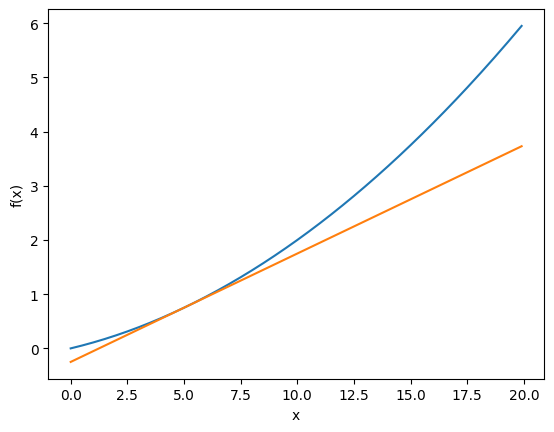

In [8]:
import numpy as np
import matplotlib.pylab as plt

# 数値微分
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

# 微分対象の関数（曲線）
def function_1(x):
    return 0.01*x**2 + 0.1*x 

# 接線を返す関数
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

# x=0-20まで0.1刻み
x = np.arange(0.0, 20.0, 0.1)

# 微分対象関数のx, y
y = function_1(x)

# x=5の接線、y2=tf(x)でx, yを計算
tf = tangent_line(function_1, 5)
y2 = tf(x)

# グラフ描画
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)  # 曲線
plt.plot(x, y2) # 接戦
plt.show()

##### 偏微分

###### 曲面のイメージ

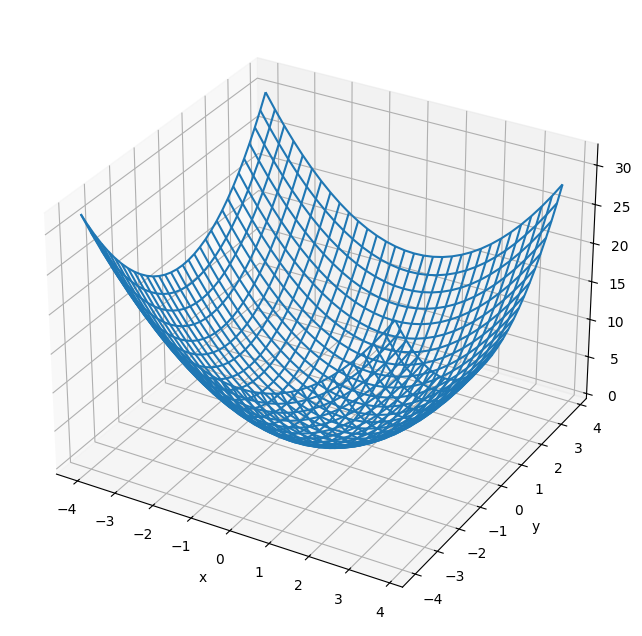

In [9]:
# x0, x1 を -4 ～ +4 まで0.25刻み
x = np.arange(-4, 4, 0.25)
y = np.arange(-4, 4, 0.25)

# 格子点（X, Y）
X, Y = np.meshgrid(x, y)

# 格、格子点でのZ
Z = X**2 + Y**2

# ワイヤーフレーム図を作成
fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3D用の設定
ax.plot_wireframe(X, Y, Z) # ワイヤーフレーム図
ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
plt.show()

###### 曲面の偏微分

In [10]:
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

# 偏微分（勾配を返す）
def numerical_gradient(f, X):
    h = 1e-4  # 0.0001
    
    # 要素の値が0の同じ形式のn行２列の行列
    grad1 = np.zeros_like(X)
        
    for idx1, x in enumerate(X):
        
        # 要素の値が0の同じ形式の２列のベクトル
        grad2 = np.zeros_like(x)
        
        for idx2 in range(x.size):
            tmp_val = x[idx2]
            
            x[idx2] = float(tmp_val) + h
            fxh1 = f(x)  # f(x+h)
            
            x[idx2] = tmp_val - h 
            fxh2 = f(x)  # f(x-h)
            
            grad2[idx2] = (fxh1 - fxh2) / (2*h)
            x[idx2] = tmp_val  # 値を元に戻す
        
        grad1[idx1] = grad2
        
    return grad1

# 偏微分対象の関数（曲面）
def function_2(x):
    return np.sum(x**2)

# 曲面の格子点での勾配を計算
# 格子点をベクトル化して
_X = X.flatten()
_Y = Y.flatten()
# n行２列の全ペアにして（.Tは転置を意味）
koushiten = np.array([_X, _Y]).T
# 格子点での勾配を返す（.Tは転置を意味）
grad = numerical_gradient(function_2, koushiten).T

###### 図示１

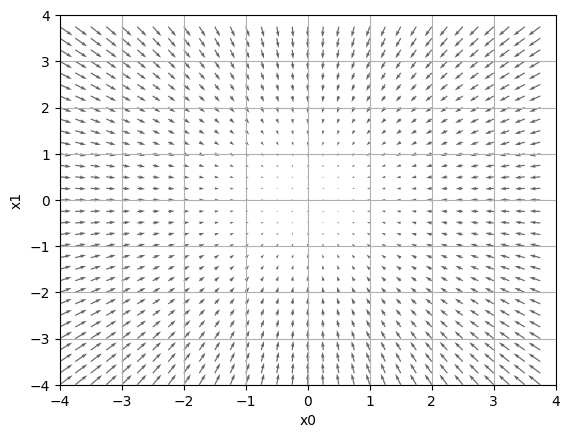

In [11]:
plt.figure()
# ベクトル場を表示
plt.quiver(_X, _Y, -grad[0], -grad[1],  angles="xy",color="#666666")
# 範囲
plt.xlim([-4, 4])
plt.ylim([-4, 4])
# 凡例
plt.xlabel('x0')
plt.ylabel('x1')

plt.grid()
plt.draw()
plt.show()

###### 図示２
等高線を足してみる。

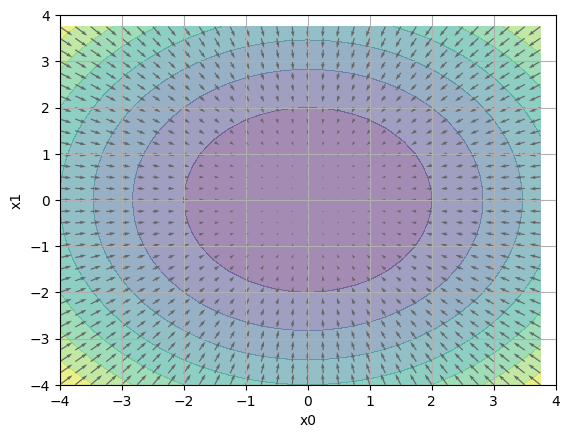

In [12]:
# 図示 
plt.figure()

# 等高線を表示 --------------------
plt.contourf(X, Y, Z, alpha=0.5)
# ---------------------------------

# ベクトル場を表示
plt.quiver(_X, _Y, -grad[0], -grad[1],  angles="xy",color="#666666")

# 範囲
plt.xlim([-4, 4])
plt.ylim([-4, 4])
# 凡例
plt.xlabel('x0')
plt.ylabel('x1')

plt.grid()
plt.draw()
plt.show()

###### 図示３
曲面に勾配を書いてみる。

/tmp/ipykernel_1382/4260932655.py:14: RuntimeWarning: invalid value encountered in divide
  ax.quiver(X, Y, Z, -dX/W, -dY/W, -W,


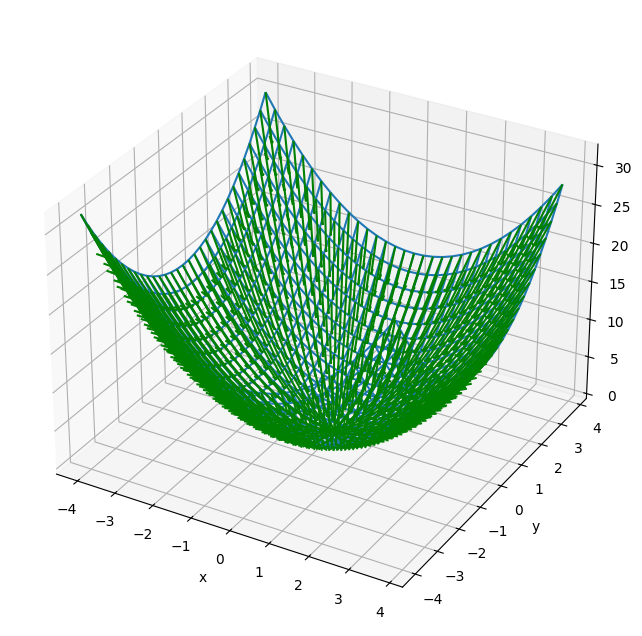

In [13]:
# 格子点のX、Y軸方向の勾配
dX = grad[0, :].reshape(X.shape)
dY = grad[1, :].reshape(Y.shape)

# Z軸方向の勾配を計算
W = np.sqrt(dX**2 + dY**2)

fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3D用の設定

# 曲面
ax.plot_wireframe(X, Y, Z) # ワイヤーフレーム図
# 勾配
ax.quiver(X, Y, Z, -dX/W, -dY/W, -W, 
          color='green', pivot='tail', arrow_length_ratio=0.1, length=0.5, label='grad') 

ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
plt.show()

#### パラメタ更新
[勾配降下法](#勾配降下法)のパラメタ更新

##### 曲面の最急降下法

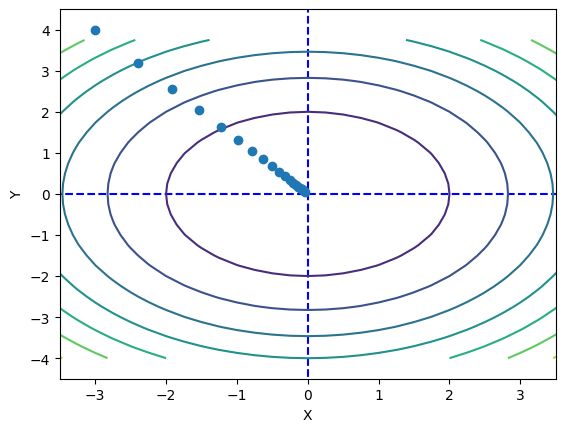

In [14]:
import numpy as np
import matplotlib.pylab as plt

# 偏微分（勾配を返す）
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
        
    # 要素の値が0の同じ形式の２列のベクトル
    grad2 = np.zeros_like(x)
        
    for idx2 in range(x.size):
        tmp_val = x[idx2]
            
        x[idx2] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
            
        x[idx2] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
            
        grad2[idx2] = (fxh1 - fxh2) / (2*h)
        x[idx2] = tmp_val  # 値を元に戻す
        
    return grad2

# 偏微分対象の関数（曲面）
def function_2(x):
    return np.sum(x**2)

# 最急降下法
# f=損失関数, init_x=開始地点, lr=学習率, step_num=計算回数
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return np.array(x_history)

# パイパーパラメタ

# 開始地点
init_x = np.array([-3.0, 4.0])  
# 計算回数
step_num = 20
# 学習率
lr = 0.1

# 最急降下法
# f=損失関数, init_x=開始地点, lr=学習率, step_num=計算回数
x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

# 図の設定
plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')

# 等高線
plt.contour(X, Y, Z)
# 更新値の推移
plt.plot(x_history[:,0], x_history[:,1], 'o')

# 範囲
plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
# ラベル
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

##### 単層ニューラルネットワークでの勾配計算
- 前述で曲面（[損失関数](#損失関数)に相当）を偏微分して勾配を計算したのに対し、  
ニューラルネットワークにおける[損失関数](#損失関数)を偏微分して勾配を計算する。  
- そもそも近似関数と[損失関数](#損失関数)の違いに注意。
  - 近似関数には重み変数が含まれ、[損失関数](#損失関数)にも重み変数が含まれる。
  - 近似関数の[損失関数](#損失関数)を重み変数で微分して重みの勾配を求める。
  - 勾配は[損失関数](#損失関数)の最小値となる点（重み）を求めるために使用。
  - [損失関数](#損失関数)の最小値となる点（重み）の値は、近似関数で最適化された重みの値となる。
- コレをニューラルネットワークに適用するとなると、
  - ニューラルネットワーク自体も近似関数で、
  - 近似関数の[損失関数](#損失関数)を重み変数で偏微分（ココでは[数値微分](#数値微分)）して勾配を計算する。
  - 各重み（行列の要素）が[損失関数](#損失関数)のx、y、zなどの変数になってコレを偏微分するイメージ。
- Import
  - [common/functions.py](Kasago/common/functions.py)
  - [common/gradient.py](Kasago/common/gradient.py)

In [15]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from kasago.common.functions import softmax, cross_entropy_error
from kasago.common.gradient import numerical_gradient

# 単層ニューラルネットワーク・クラス
class simpleNet:

    def __init__(self):
        # 初期化
        
        # ランダムな重み
        self.W = np.random.randn(2,3)

    def predict(self, x):
        # 推論
        
        # ベクトルと重みの積算
        y = np.dot(x, self.W)
        
        # Softmax
        return softmax(y)
        
    def loss(self, x, t):
        # 勾配計算用関数
        
        # 推論
        y = self.predict(x)
        
        # 損失関数
        loss = cross_entropy_error(y, t)

        return loss

# 入力（ベクトル
x = np.array([0.6, 0.9])
# 教師（ベクトル
t = np.array([0, 0, 1])

# 単層ニューラルネットワーク・インスタンス
net = simpleNet()

# 勾配計算用関数
f = lambda w: net.loss(x, t)
# 勾配計算（数値微分）
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.19175373  0.20094493 -0.39269866]
 [ 0.28763059  0.3014174  -0.58904799]]


##### ２層ニューラルネットワークの勾配
２層ニューラルネットワークで実際に重みやバイアス毎に勾配を計算する。
- 通常版：[数値微分](#数値微分)で偏微分を近似し勾配を計算する。
- 高速版：[誤差逆伝播法](KasagoDL3.ipynb)で偏微分を近似し勾配を計算する。

勾配によって更新した重みやバイアスを使用して、学習を繰り返す。

###### 学習＆推論
- Import
  - [dataset/mnist.py](Kasago/dataset/mnist.py)
  - [common/functions.py](Kasago/common/functions.py)
  - [common/gradient.py](Kasago/common/gradient.py)

In [16]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from kasago.dataset.mnist import load_mnist
from kasago.common.functions import *
from kasago.common.gradient import numerical_gradient

# ２層ニューラルネットワーク・クラス
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # パラメタ（重みとバイアス）の初期化
        self.params = {}
        
        # ランダムな重み
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        # バイアス（０
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        # 推論
        
        # 重み
        W1, W2 = self.params['W1'], self.params['W2']
        
        # バイアス
        b1, b2 = self.params['b1'], self.params['b2']
        
        # 隠れ層
        # ベクトルと重みの積算＋バイアス
        a1 = np.dot(x, W1) + b1
        # 活性化関数（Sigmoid関数
        z1 = sigmoid(a1)
        
        # 出力層
        # ベクトルと重みの積算＋バイアス
        a2 = np.dot(z1, W2) + b2
        # 活性化関数（Softmax関数
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):        
        # 勾配計算用関数
        
        # 推論
        y = self.predict(x)
        
        # 損失関数
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        # 正解率計算用関数
        
        # 推論（分類
        y = self.predict(x)
        
        # y, tを揃える
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        # 正解率の計算
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    # 学習（確認用）
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        # 数値微分による勾配計算により、
        # predictとLearnを行う。
        
        # 勾配計算用関数
        loss_W = lambda W: self.loss(x, t)
        
        # 勾配計算
        # ヤヤコシイが
        #  - ココのnumerical_gradientはself.numerical_gradientじゃない。
        #  - なお、self.predictは、self.lossの中で実行されている。
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # 学習（高速版）
    # x:入力データ, t:教師データ
    def gradient(self, x, t):
        # 誤差逆伝播法による勾配計算により、
        # predictとLearnを行う。
        
        # 勾配の計算
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        # forward（predict
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward（Learn
        grads = {}
        batch_num = x.shape[0]

        # 出力層 --------------------
        # softmaxレイヤの逆伝播
        dy = (y - t) / batch_num
        
        # Affineレイヤの逆伝播
        # np.dot(X, W) + B
        ## 重み W
        grads['W2'] = np.dot(z1.T, dy)
        ## バイアス B
        grads['b2'] = np.sum(dy, axis=0)
        ## 入力 X
        dz1 = np.dot(dy, W2.T)
        # ---------------------------
        
        # 中間層 --------------------
        # sigmoidレイヤの逆伝播
        da1 = sigmoid_grad(a1) * dz1
        
        # Affineレイヤの逆伝播
        # np.dot(X, W) + B
        ## 重み W
        grads['W1'] = np.dot(x.T, da1)
        ## バイアス B
        grads['b1'] = np.sum(da1, axis=0)
        ## 入力 X
        # これ以上、逆伝播シないので計算不要
        # ---------------------------

        return grads

In [17]:
import sys, os
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from kasago.dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ２層ニューラルネットワークの初期化
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# パイパーパラメタ

# 繰り返し回数を適宜設定する
iters_num = 10000
# 学習率
learning_rate = 0.1

# 訓練データサイズ
train_size = x_train.shape[0]
# バッチサイズ
batch_size = 100
# サブセット数（イテレーション数）
iter_per_epoch = max(train_size / batch_size, 1)

# データサイズ / バッチサイズ = サブセット数になる。
# サブセット数は、そのまま、単位エポック毎のイテレーション数になる。
# 繰り返し回数をサブセット数（イテレーション数）で割るとエポック数になる。
# 繰り返し回数 * バッチサイズ = 実際に学習するデータの件数になる。
print("iters_num = %d" % iters_num)
print("train_size : batch_size = %d : %d" % (train_size, batch_size))
print("iter_per_epoch ≒ train_size / batch_size = %d" % iter_per_epoch)
print("epoch_num = iters_num / iter_per_epoch = %d" % (iters_num / iter_per_epoch))

# 結果を格納する変数
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(iters_num): # 繰り返し回数
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 学習
    
    # 数値微分は、都度、推論が必要なので遅過ぎて使えない。
    # grad = network.numerical_gradient(x_batch, t_batch)
    # 誤差逆伝播法の実用可能な高速版
    grad = network.gradient(x_batch, t_batch)
    
    # パラメタ（重みとバイアス）の更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 損失の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0: # エポック毎
        
        # 正解率の計算
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        # 正解率の記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
print("train and test have been completed.")

iters_num = 10000
train_size : batch_size = 60000 : 100
iter_per_epoch ≒ train_size / batch_size = 600
epoch_num = iters_num / iter_per_epoch = 16
train acc, test acc | 0.09035, 0.0892
train acc, test acc | 0.7828833333333334, 0.7886
train acc, test acc | 0.8760333333333333, 0.88
train acc, test acc | 0.8986166666666666, 0.9021
train acc, test acc | 0.9090666666666667, 0.9128
train acc, test acc | 0.9156166666666666, 0.9191
train acc, test acc | 0.9210833333333334, 0.9241
train acc, test acc | 0.9245833333333333, 0.9264
train acc, test acc | 0.92885, 0.9298
train acc, test acc | 0.9323666666666667, 0.934
train acc, test acc | 0.9349833333333334, 0.9357
train acc, test acc | 0.9373666666666667, 0.9371
train acc, test acc | 0.9400333333333334, 0.9398
train acc, test acc | 0.94275, 0.9417
train acc, test acc | 0.9438, 0.943
train acc, test acc | 0.9467166666666667, 0.944
train acc, test acc | 0.94785, 0.9456
train and test have been completed.


###### 推移の描画

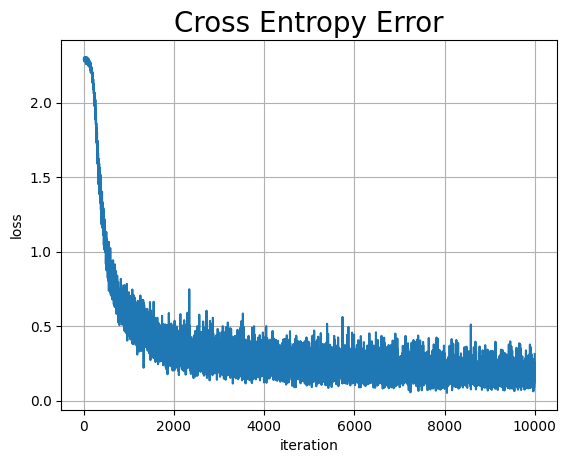

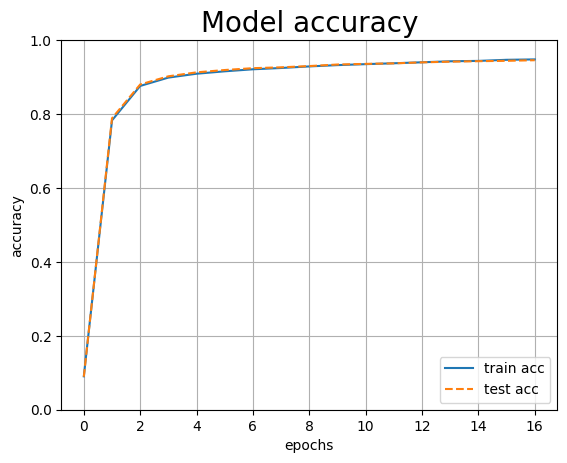

In [18]:
import matplotlib.pyplot as plt

# 損失の推移の描画
# タイトル
plt.title('Cross Entropy Error', fontsize=20)
# グリッド線
plt.grid()
# 折れ線グラフ
plt.plot(np.arange(1, iters_num + 1), train_loss_list)
# 軸ラベル
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# 正解率の推移の描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
# 範囲
plt.ylim(0, 1.0)
# タイトル
plt.title('Model accuracy', fontsize=20)
# グリッド線
plt.grid()
# 折れ線グラフ
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
# 軸ラベル
plt.xlabel("epochs")
plt.ylabel("accuracy")
# 凡例
plt.legend(loc='lower right')
plt.show()